In [13]:
import sys
sys.path.append("/home/renatomz/Documents/Projects/dalio")

In [12]:
!{sys.executable} -m pip install arch
!{sys.executable} -m pip install PyPortfolioOpt
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas_datareader
!{sys.executable} -m pip install quandl

  Using cached PyPortfolioOpt-1.2.2-py3-none-any.whl (49 kB)


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dalio.base.constants import *
from dalio.external import * 
from dalio.translator import *
from dalio.pipe import *
from dalio.model import *
from dalio.application import *


# Yahoo Input
y_api = YahooDR()
y_in = YahooStockTranslator()(y_api)

# Quandl Input
q_api = QuandlAPI("/home/renatomz/Documents/Projects/dalio/dalio/external/config/quandl_config.json")
q_api.authenticate()

q_sf1_in = QuandlSharadarSF1Translator()(q_api)
q_tick_in = QuandlTickerInfoTranslator()(q_api)

tickers = ["MSFT", "AAPL", "IBM", "TSLA", "XOM", "BP", "JPM", "GOOG", "GE"]

In [53]:
y_data_raw = y_in.run(ticker=tickers)
q_data_raw = q_sf1_in.run(ticker=tickers)

/home/renatomz/anaconda3/lib/python3.7/site-packages/pandas_datareader/data.py:387: ResourceWarning: unclosed <socket.socket fd=55, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.12.101', 37636), raddr=('66.218.84.42', 443)>
  session=session,
/home/renatomz/anaconda3/lib/python3.7/site-packages/quandl/model/datatable.py:28: ResourceWarning: unclosed <socket.socket fd=54, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.12.101', 34206), raddr=('45.223.27.172', 443)>
  return Data.page(self, **options)


In [55]:
y_data_raw.adj_close

ticker,MSFT,AAPL,IBM,TSLA,XOM,BP,JPM,GOOG,GE,SNAP
date,,,,,,,,,,
2015-06-08,41.386757,117.781601,133.033630,256.290009,68.715355,28.991108,58.081524,526.830017,22.721949,NaN
2015-06-09,41.314346,117.431381,133.307190,256.000000,68.496689,29.005411,58.333328,526.690002,22.797020,NaN
2015-06-10,42.183174,118.776917,135.914154,250.699997,69.006905,29.527582,59.271114,536.690002,23.047262,NaN
2015-06-11,42.029312,118.509666,135.801468,251.410004,68.909721,29.627728,59.496872,534.609985,22.947161,NaN
2015-06-12,41.603962,117.200966,134.361221,250.690002,68.043182,29.184237,59.262421,532.330017,22.847061,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-06-01,182.830002,321.850006,124.889999,898.099976,46.279999,23.840000,98.599998,1431.819946,6.760000,19.549999
2020-06-02,184.910004,323.339996,126.000000,881.559998,47.310001,24.950001,98.930000,1439.219971,7.050000,19.750000
2020-06-03,185.360001,325.119995,129.050003,882.960022,49.240002,25.900000,104.269997,1436.380005,7.360000,19.730000


In [ ]:
cols=["close", "high"]
y_change = Change(cols)(y_in)
y_col_select = ColSelect(cols)(y_in)
y_custom = Custom(lambda x: x / x)(y_in)
y_index = Index(index_at=100, cols=cols)(y_in)
y_period = Period(period="Y")(y_in)

y_data_change = y_change.run(ticker=tickers)
y_data_col_select = y_col_select.run(ticker=tickers)
y_data_custom = y_custom.run(ticker=tickers)
y_data_index = y_index.run(ticker=tickers)
y_data_period = y_period.run(ticker=tickers)

cols=["evebitda", "fcf", "price"]
q_change = Change(cols)(q_sf1_in)
q_col_select = ColSelect(cols)(q_sf1_in)
q_custom = Custom(lambda x: 42)(q_sf1_in)
q_index = Index(index_at=100, cols=cols)(q_sf1_in)
q_period = Period(period="Y")(q_sf1_in)

q_comps = StockComps(strategy="sic_code", max_ticks=None)(q_tick_in)

q_data_change = q_change.run(ticker=tickers)
q_data_col_select = q_col_select.run(ticker=tickers)
q_data_custom = q_custom.run(ticker=tickers)
q_data_index = q_index.run(ticker=tickers)
q_data_period = q_period.run(ticker=tickers)
q_data_comps = q_comps.run(
    ticker="MSFT", 
    filters={"table":"SF1"}
)

q_comps_financials = CompsFinancials()("comps_in", q_comps)("data_in", q_sf1_in)
q_data_comps_financials = q_comps_financials.run(ticker="MSFT")

q_comps_prices = q_comps_financials.with_input("data_in", y_in)
q_data_comps_prices = q_comps_prices.run(ticker="MSFT")

q_comps_printer = Printer()\
    .set_input("data_in", q_sf1_in)\
    .set_output("data_out", FileWriter())
q_comps_printer.run(ticker=tickers)

q_comps_grapher = PandasTSGrapher(y=CLOSE)\
    .set_input("data_in", y_in)\
    .set_output("data_out", PyPlotGraph())

q_comps_grapher.run(ticker=tickers)
PyPortfolioOpt

In [57]:
adj_close_in = ColSelect(cols=("adj_close"))(y_in)

In [58]:
garch = MakeARCH()(adj_close_in)

garch\
    .set_piece("mean", "ARX", lags=[1, 3, 12])\
    .set_piece("volatility", "ARCH", p=5)\
    .set_piece("distribution", "StudentsT")

res = garch.run(ticker="MSFT")

/home/renatomz/anaconda3/lib/python3.7/site-packages/pandas_datareader/data.py:387: ResourceWarning: unclosed <socket.socket fd=54, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.12.101', 41994), raddr=('66.218.84.43', 443)>
  session=session,


Iteration:      1,   Func. Count:     13,   Neg. LLF: 1893.9027169691549
Iteration:      2,   Func. Count:     36,   Neg. LLF: 9897.192533126257
Iteration:      3,   Func. Count:     51,   Neg. LLF: 9772.707042310121
Iteration:      4,   Func. Count:     64,   Neg. LLF: 9580.603773030236
Iteration:      5,   Func. Count:     78,   Neg. LLF: 9467.066093918256
Iteration:      6,   Func. Count:     92,   Neg. LLF: 9208.97254176448
Iteration:      7,   Func. Count:    106,   Neg. LLF: 8565.229052578463
Iteration:      8,   Func. Count:    129,   Neg. LLF: 12811.971854566891
Iteration:      9,   Func. Count:    143,   Neg. LLF: 11160.42679607155
Iteration:     10,   Func. Count:    156,   Neg. LLF: 10292.597393801665
Iteration:     11,   Func. Count:    171,   Neg. LLF: 8345.071606484571
Iteration:     12,   Func. Count:    188,   Neg. LLF: 8279.569441508012
Iteration:     13,   Func. Count:    207,   Neg. LLF: 8143.075527291322
Iteration:     14,   Func. Count:    224,   Neg. LLF: 8012.376

/home/renatomz/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


In [59]:
S = CovShrink()(ajd_close_in)
S.set_piece("shrinkage", "ledoit_wolf")

mu = ExpectedReturn()(ajd_close_in)
mu.set_piece("return_model", "mean_historical_return")

S_data = S.run(ticker=tickers)
mu_data = mu.run(ticker=tickers)

port_ef = OptimumWeights()\
    .set_input("sample_covariance", S)\
    .set_input("expected_returns", mu)

port_ef\
    .add_objective("L2_reg")\
    .add_constraint(lambda x: x[1] <= 0.5)\
    .add_stock_weight_constraint(
        ticker="MSFT",
        comparisson="==",
        weight=0.3)\
    .set_piece("strategy", "max_sharpe")

ef = port_ef.run(ticker=tickers)

/home/renatomz/anaconda3/lib/python3.7/site-packages/pandas_datareader/data.py:387: ResourceWarning: unclosed <socket.socket fd=54, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.12.101', 41996), raddr=('66.218.84.43', 443)>
  session=session,
/home/renatomz/anaconda3/lib/python3.7/site-packages/pandas_datareader/data.py:387: ResourceWarning: unclosed <socket.socket fd=54, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.12.101', 37646), raddr=('66.218.84.42', 443)>
  session=session,
/home/renatomz/anaconda3/lib/python3.7/site-packages/pandas_datareader/data.py:387: ResourceWarning: unclosed <socket.socket fd=54, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.12.101', 42000), raddr=('66.218.84.43', 443)>
  session=session,
/home/renatomz/anaconda3/lib/python3.7/site-packages/pandas_datareader/data.py:387: ResourceWarning: unclosed <socket.socket fd=54, family=AddressFamily.AF_I

In [60]:
cla = CLA(mu_data, S_data)

In [61]:
mu, sigma, weights = cla.efficient_frontier(points=1000)

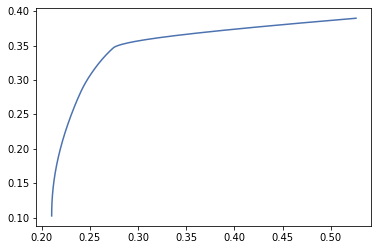

In [51]:
plt.plot(sigma, mu)

In [62]:
cla.plot_efficient_frontier(points=100)

/home/renatomz/anaconda3/lib/python3.7/site-packages/pypfopt/cla.py:453: UserWarning: This method is deprecated and will be removed in v1.2.0. Please use pypfopt.plotting instead
  "This method is deprecated and will be removed in v1.2.0. "


ValueError: Weights is None